In [158]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import copy
import pickle
import io
from simulators.turin import turin

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [123]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

        
def load_models(root_name: str, device: torch.device):
    sum_net = torch.load(f"{root_name}/sum_net.pkl", map_location=device)

    density_estimator = torch.load(f"{root_name}/density_estimator.pkl", map_location=device)

    with open(f"{root_name}/posterior.pkl", "rb") as handle:
        posterior = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
    
    return sum_net, density_estimator, posterior


def read_rnpe(model="ricker", misspecified=0, seed=1, theta=[4,10]):
    file = f"seed={seed}_var={misspecified}_theta={theta}_{model}"

    results_dir = f"objects/rnpe/{model}/"
    fn = f"{results_dir}/{file}.pickle"

    with open(fn, "rb") as f:
        results = pickle.load(f)

    return np.array(results['posterior_samples']['RNPE'])


def sample_posteriors(posterior, obs, num):
    return posterior.sample((num,), x=obs.reshape(1, 1, 100, 100), show_progress_bars=False)

In [162]:
prior = [[1e-9, 1e-8],[1e-9, 1e-8], [1e7, 5e9], [1e-10, 1e-9]]

theta = torch.tensor(np.load("data/turin_theta_1000.npy"))
x = torch.tensor(np.load("data/turin_x_1000.npy")).reshape(1000, 100, 801)

In [1]:
def TurinModel(G0, T, lambda_0, sigma2_N, B = 4e9, Ns = 801, N = 100, tau0 = 0):
  
    nRx = N

    delta_f = B/(Ns-1)   # Frequency step size
    t_max = 1 / delta_f

    tau = np.linspace(0, t_max, Ns)

    H = np.zeros((nRx, Ns), dtype=complex)

    mu_poisson = lambda_0*t_max # Mean of Poisson process

    for jR in range(nRx):

        n_points = np.random.poisson(mu_poisson) # Number of delay points sampled from Poisson process

        delays = np.random.uniform(0, t_max, n_points) # Delays sampled from a 1-dimensional Poisson point process

        delays = np.sort(delays)


        alpha = np.zeros(n_points, dtype=complex)   # Initialising vector of gains of length equal to the number of delay points

        sigma2 = G0*np.exp(-delays/T)/lambda_0 * B

        for l in range(n_points):
            alpha[l] = np.random.normal(0, np.sqrt(sigma2[l]/2)) + np.random.normal(0, np.sqrt(sigma2[l]/2))*1j

        H[jR, :] = np.exp(-1j*2*np.pi*delta_f * (np.outer(np.arange(Ns), delays))) @ alpha

    # Noise power by setting SNR
    Noise = np.zeros((nRx, Ns), dtype=complex)

    for j in range(nRx):
        Noise[j, :] = np.random.normal(0, np.sqrt(sigma2_N/2), Ns) + np.random.normal(0, np.sqrt(sigma2_N/2), Ns) * 1j

    # Received signal in frequency domain
    
    Y = H + Noise

    return Y

In [84]:
def TurinModel_torch(G0, T, lambda_0, sigma2_N, B = 4e9, Ns = 801, N = 100, tau0 = 0):
    sigma2_N = torch.tensor(sigma2_N)
    nRx = N

    delta_f = B/(Ns-1)   # Frequency step size
    t_max = 1 / delta_f

    tau = torch.linspace(0, t_max, Ns)

    H = torch.zeros((nRx, Ns), dtype=torch.cfloat)

    mu_poisson = torch.tensor(lambda_0*t_max) # Mean of Poisson process

    for jR in range(nRx):

        n_points = int(torch.poisson(mu_poisson)) # Number of delay points sampled from Poisson process

        delays = torch.rand(n_points) * t_max # Delays sampled from a 1-dimensional Poisson point process

        delays = torch.sort(delays)[0]


        alpha = torch.zeros(n_points, dtype=torch.cfloat)   # Initialising vector of gains of length equal to the number of delay points

        sigma2 = G0*torch.exp(-delays/T)/lambda_0 * B

        for l in range(n_points):
            alpha[l] = torch.normal(0, torch.sqrt(sigma2[l]/2)) + torch.normal(0, torch.sqrt(sigma2[l]/2))*1j

        H[jR, :] = torch.matmul(torch.exp(-1j*2*np.pi*delta_f * (torch.ger(torch.arange(Ns), delays))), alpha)

    # Noise power by setting SNR
    Noise = torch.zeros((nRx, Ns), dtype=torch.cfloat)

    for j in range(nRx):
        normal = torch.distributions.normal.Normal(0, torch.sqrt(sigma2_N/2))
        Noise[j, :] = normal.sample([Ns]) + normal.sample([Ns]) * 1j

    # Received signal in frequency domain
    
    Y = H + Noise
    
    y = np.zeros(Y.shape, dtype=complex)
    p = np.zeros(Y.shape)
    lens = len(Y[:,0])

    for i in range(lens):
        y[i,:] = np.fft.ifft(Y[i,:])

        p[i,:] = np.abs(y[i,:])**2
    
    return 10 * np.log10(p)

In [66]:
def apdp(Y):
    y = np.zeros(Y.shape, dtype=complex)
    p = np.zeros(Y.shape)
    lens = len(Y[:,0])

    for i in range(lens):
        y[i,:] = np.fft.ifft(Y[i,:])

        p[i,:] = np.abs(y[i,:])**2
    return 10 * np.log10(np.mean(p,axis=0))

def pdp(Y):
    y = np.zeros(Y.shape, dtype=complex)
    p = np.zeros(Y.shape)
    lens = len(Y[:,0])

    for i in range(lens):
        y[i,:] = np.fft.ifft(Y[i,:])

        p[i,:] = np.abs(y[i,:])**2
    return 10 * np.log10(np.mean(p,axis=0))

(100, 801)


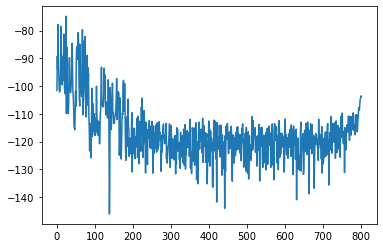

In [172]:
G0 = 10**(-8.4)
# G0 = 1e-8
T = 7.8e-9
# T = 1e-9
lambda_0 = 1e9
# sigma2_N = 2.8e-10
sigma2_N = 1e-9
Y = TurinModel_torch(G0, T, lambda_0, sigma2_N)
print(Y.shape)
plt.plot(np.arange(801), Y[1])
plt.show()

In [104]:
theta = np.load("data/turin_theta_1000.npy")
x = np.load("data/turin_x_1000.npy").reshape(1000, 100, 801)

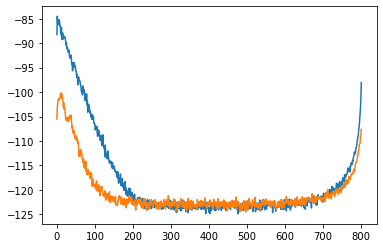

In [120]:
plt.plot(np.arange(801), np.mean(x[20], axis=0))
plt.plot(np.arange(801), np.mean(x[3], axis=0))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

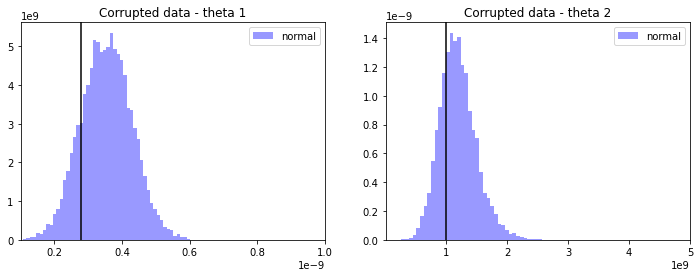

In [218]:
theta_gt = torch.tensor([10**(-8.4), 7.8e-9, 1e9, 2.8e-10])
simulator = turin(B=4e9, Ns=801, N=100, tau0=0)
obs = simulator(theta_gt).to(device)

# root_name = "objects/turin/var=40.0_mmd_beta=0.01_theta=[4, 10]_num=1000/5"
# sum_net_robust, density_estimator_robust, posterior_robust = load_models(root_name, device)

root_name = "objects/turin/none_beta=1.0_num=1000_N=100/26"
sum_net_normal, density_estimator_normal, posterior_normal = load_models(root_name, device)

post_samples_normal_cont = posterior_normal.sample((10000,), x=obs.reshape(1, 1, 100, 801))
# post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))

plt.figure(figsize=(12,4))
idx = 3
plt.subplot(1, 2, 1)
plt.axvline(x=theta_gt[idx],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, idx].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
# sns.distplot(post_samples_robust_cont[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(prior[idx][0], prior[idx][1])
plt.title("Corrupted data - theta 1")

plt.subplot(1, 2, 2)
idx = 2
plt.axvline(x=theta_gt[idx],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, idx].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
# sns.distplot(post_samples_robust_cont[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(prior[idx][0], prior[idx][1])
plt.title("Corrupted data - theta 2")
plt.show()


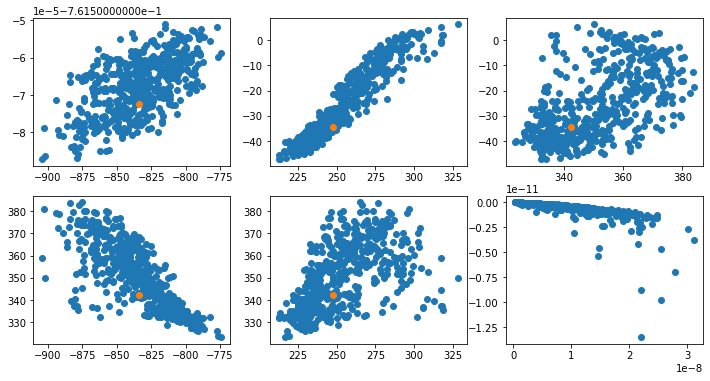

In [166]:
sum_net_normal_0 = copy.deepcopy(sum_net_normal)

obs_summary = sum_net_normal_0(obs.unsqueeze(0))[1].detach().numpy()

x_summary = sum_net_normal_0(x[:500])[1].detach().numpy()

plt.figure(figsize=(12,6))
plt.subplot(2, 3, 1)
plt.scatter(x_summary[:, 0], x_summary[:, 4])
plt.scatter(obs_summary[0, 0], obs_summary[0, 4])

plt.subplot(2, 3, 2)
plt.scatter(x_summary[:, 1], x_summary[:, 3])
plt.scatter(obs_summary[0, 1], obs_summary[0, 3])

plt.subplot(2, 3, 3)
plt.scatter(x_summary[:, 2], x_summary[:, 3])
plt.scatter(obs_summary[0, 2], obs_summary[0, 3])

plt.subplot(2, 3, 4)
plt.scatter(x_summary[:, 0], x_summary[:, 2])
plt.scatter(obs_summary[0, 0], obs_summary[0, 2])
plt.subplot(2, 3, 5)
plt.scatter(x_summary[:, 1], x_summary[:, 2])
plt.scatter(obs_summary[0, 1], obs_summary[0, 2])

plt.subplot(2, 3, 6)
plt.scatter(x_summary[:, 6], x_summary[:, 7])
# plt.scatter(obs_summary[0, 0], obs_summary[0, 1])
plt.show()